# BMTF input stubs fit with a Deep Learning approach

## Imports and setup

In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep

import os
import warnings

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, callbacks, regularizers

In [227]:
hep.style.use("CMS")

warnings.filterwarnings("ignore")

mpl.rcParams["figure.dpi"] = 70

In [228]:
print(f"Training device: {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}")

Training device: GPU


## Constants

In [229]:
USER = os.getenv("USER")

# FILE_PATH = "/eos/cms/store/cmst3/group/daql1scout/ml_data/run3/bmtf_stubs_refit/"
FILE_PATH = "/mnt/ml_data/run3/bmtf_stubs_refit/"

FILE_SAVE_DATA = "/mnt/ml_data/run3/bmtf_stubs_refit_dummy/Data3NN/"

FILE_NAME = "rereco"

OUT_PATH = "."
LOSS_FNAME = "losses_2_classification.csv"

FIGSIZE = (12, 7)

petroff_10 = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
plt.rcParams["axes.prop_cycle"] = plt.cycler('color', petroff_10)

## Classes

### Neural Network model for regression+classification task

In [230]:
class MultiTaskNN(tf.keras.Model):
    def __init__(self, architecture, reg_strength=0.01):
        super(MultiTaskNN, self).__init__()

        # Check if the architecture list has at least 2 values (input size and one hidden layer)
        if len(architecture) < 2:
            raise ValueError("Architecture must contain at least input size and one hidden layer.")

        self.layers_list = []

        # Iterate over the architecture list to dynamically create dense layers followed by batch normalization
        for i in range(1, len(architecture)):
            self.layers_list.append(layers.Dense(architecture[i], kernel_regularizer=regularizers.l2(reg_strength)))
            self.layers_list.append(layers.Activation('elu'))

        self.classification_head = layers.Dense(1, kernel_regularizer=regularizers.l2(reg_strength))  # for charge
        # self.classification_head = layers.Dense(1, activation="sigmoid", kernel_regularizer=regularizers.l2(reg_strength))  # for charge

    def call(self, inputs):
        x = inputs
        for layer in self.layers_list:
            x = layer(x)

        class_output = self.classification_head(x)
        return class_output

### Custom Learning Rate scheduler

In [231]:
# Custom learning rate scheduler callback
class CustomLRScheduler(tf.keras.callbacks.Callback):
    def __init__(
        self, 
        optimizer, 
        factor=0.5, 
        patience=5, 
        min_improvement=0.01, 
        verbose=True
    ):
        super(CustomLRScheduler, self).__init__()
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.min_improvement = min_improvement
        self.verbose = verbose
        self.best_loss = float('inf')
        self.patience_counter = 0

        
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
            self.optimizer.lr.assign(self.min_lr)
        if epoch < self.decrease_epoch:
            self.increase_flag = True
        else:
            self.increase_flag = False


    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get("val_loss")

        if loss:
            relative_improvement = (self.best_loss - loss) / self.best_loss

            if relative_improvement < self.min_improvement:
                self.patience_counter += 1
            else:
                self.patience_counter = 0
                self.best_loss = loss

            if self.patience_counter >= self.patience:
                self._decrease_lr()

    def _decrease_lr(self):
        old_lr = self.optimizer.lr.numpy()
        new_lr = old_lr * self.factor
        self.optimizer.lr.assign(new_lr)
        if self.verbose:
            print(f"Decreasing learning rate to {new_lr}")

## Normalizations

In [232]:
n_stubs_norm         = 2**2
station_norm         = 2**2
sector_norm          = 2**3
wheel_norm           = 2**1
eta_norm             = 2**8
qeta_norm            = 2**1
tag_norm             = 2**0
phi_norm             = 2**11
phib_norm            = 2**9
quality_norm         = 2**3
reco_pt_norm         = 2**0
reco_pt_inverse_norm = 2**0
reco_eta_norm        = 2**2
reco_phi_norm        = 2**2
reco_charge_norm     = 2**0
info_norm          = 2**2

normalizations = {
    "n_stubs": n_stubs_norm,
    "info_a": info_norm,
    "info_b": info_norm,
    "info_c": info_norm,
    "info_d": info_norm,
    "a_stNum": station_norm,
    "a_scNum": sector_norm,
    "a_whNum": wheel_norm,
    "a_eta_1": eta_norm,
    "a_qeta_1": qeta_norm,
    "a_eta_2": eta_norm,
    "a_qeta_2": qeta_norm,
    "a_tag": tag_norm,
    "a_phi": phi_norm,
    "a_phiB": phib_norm,
    "a_quality": quality_norm,
    "b_stNum": station_norm,
    "b_scNum": sector_norm,
    "b_whNum": wheel_norm,
    "b_eta_1": eta_norm,
    "b_qeta_1": qeta_norm,
    "b_eta_2": eta_norm,
    "b_qeta_2": qeta_norm,
    "b_tag": tag_norm,
    "b_phi": phi_norm,
    "b_phiB": phib_norm,
    "b_quality": quality_norm,
    "c_stNum": station_norm,
    "c_scNum": sector_norm,
    "c_whNum": wheel_norm,
    "c_eta_1": eta_norm,
    "c_qeta_1": qeta_norm,
    "c_eta_2": eta_norm,
    "c_qeta_2": qeta_norm,
    "c_tag": tag_norm,
    "c_phi": phi_norm,
    "c_phiB": phib_norm,
    "c_quality": quality_norm,
    "d_stNum": station_norm,
    "d_scNum": sector_norm,
    "d_whNum": wheel_norm,
    "d_eta_1": eta_norm,
    "d_qeta_1": qeta_norm,
    "d_eta_2": eta_norm,
    "d_qeta_2": qeta_norm,
    "d_tag": tag_norm,
    "d_phi": phi_norm,
    "d_phiB": phib_norm,
    "d_quality": quality_norm,
    # "ptReco": reco_pt_norm,
    "ptRecoInverse": reco_pt_inverse_norm,
    "etaExtRecoSt2": reco_eta_norm,
    "phiExtRecoSt2": reco_phi_norm,
    "chargeReco": reco_charge_norm,
}


In [233]:
stub_features_2 = [
    'info_a', 'info_b',
    'a_stNum', 'a_scNum', 'a_whNum', 'a_eta_1', 'a_qeta_1', 'a_eta_2', 'a_qeta_2', 'a_tag', 'a_phi', 'a_phiB', 'a_quality',
    'b_stNum', 'b_scNum', 'b_whNum', 'b_eta_1', 'b_qeta_1', 'b_eta_2', 'b_qeta_2', 'b_tag', 'b_phi', 'b_phiB', 'b_quality'
]

stub_features_3 = [
    'info_a', 'info_b', 'info_c',
    'a_stNum', 'a_scNum', 'a_whNum', 'a_eta_1', 'a_qeta_1', 'a_eta_2', 'a_qeta_2', 'a_tag', 'a_phi', 'a_phiB', 'a_quality',
    'b_stNum', 'b_scNum', 'b_whNum', 'b_eta_1', 'b_qeta_1', 'b_eta_2', 'b_qeta_2', 'b_tag', 'b_phi', 'b_phiB', 'b_quality',
    'c_stNum', 'c_scNum', 'c_whNum', 'c_eta_1', 'c_qeta_1', 'c_eta_2', 'c_qeta_2', 'c_tag', 'c_phi', 'c_phiB', 'c_quality'
]

stub_features_4 = [
    
    'a_stNum', 'a_scNum', 'a_whNum', 'a_eta_1', 'a_qeta_1', 'a_eta_2', 'a_qeta_2', 'a_tag', 'a_phi', 'a_phiB', 'a_quality',
    'b_stNum', 'b_scNum', 'b_whNum', 'b_eta_1', 'b_qeta_1', 'b_eta_2', 'b_qeta_2', 'b_tag', 'b_phi', 'b_phiB', 'b_quality',
    'c_stNum', 'c_scNum', 'c_whNum', 'c_eta_1', 'c_qeta_1', 'c_eta_2', 'c_qeta_2', 'c_tag', 'c_phi', 'c_phiB', 'c_quality',
    'd_stNum', 'd_scNum', 'd_whNum', 'd_eta_1', 'd_qeta_1', 'd_eta_2', 'd_qeta_2', 'd_tag', 'd_phi', 'd_phiB', 'd_quality'
]

target_features = [
 'chargeReco'
]

l1_features = [
    'ptL1', 'etaL1', 'phiL1', 'hwSignL1',
]

## Read data

In [234]:
#create 3 datasets data_2
data_2 = pd.read_csv(FILE_SAVE_DATA + 'data_2s.csv')
data_3 = pd.read_csv(FILE_SAVE_DATA + 'data_3s.csv')
data_4 = pd.read_csv(FILE_SAVE_DATA + 'data_4s.csv')

#remove n_stubs from data_2
data_2 = data_2.drop(columns=['n_stubs'])
data_3 = data_3.drop(columns=['n_stubs'])
data_4 = data_4.drop(columns=['n_stubs'])


#remove info_a, info_b, info_c, info_d from data_4
data_4 = data_4.drop(columns=['info_a', 'info_b', 'info_c', 'info_d'])

In [235]:
data_4

,a_stNum,a_scNum,a_whNum,a_eta_1,a_qeta_1,a_eta_2,a_qeta_2,a_tag,a_phi,a_phiB,...,d_phiB,d_quality,ptRecoInverse,etaExtRecoSt2,phiExtRecoSt2,chargeReco,ptL1,etaL1,phiL1,hwSignL1
0,1,8,1,7,0,7,0,1,-153,130,...,32,5,0.162074,0.601459,-2.10473,0,9.0,0.598125,-2.09440,1
1,1,4,-1,-46,1,255,0,1,-427,89,...,29,2,0.106646,-0.486673,2.01145,0,10.5,-0.489375,2.00713,1
2,1,2,1,7,0,7,0,1,8,174,...,-37,6,0.182156,0.547758,1.07746,0,6.5,0.554625,1.10174,1
3,1,8,0,0,2,255,0,1,732,-91,...,9,6,0.114194,0.033843,-1.94995,1,10.5,0.010875,-1.94168,0
4,1,10,1,7,0,7,0,1,-151,-113,...,4,6,0.150777,0.651324,-1.13543,1,10.5,0.641625,-1.11265,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686165,1,9,0,7,2,255,0,1,-360,-54,...,-9,5,0.063276,0.067195,-1.67440,1,19.5,0.054375,-1.67988,0
686166,1,9,0,7,2,255,0,1,-360,-54,...,-9,5,0.060426,0.048062,-1.66768,1,19.5,0.054375,-1.67988,0
686167,1,10,1,7,0,7,0,1,313,-83,...,-1,6,0.113663,0.763765,-1.00096,1,11.0,0.717750,-1.00356,0
686168,1,10,-1,7,0,7,0,1,225,-92,...,11,5,0.117008,-0.757491,-1.01835,1,10.5,-0.717750,-1.02538,0


## Train Test Split for the 3 datasets

In [236]:
train_val_data_2, test_data_2 = train_test_split(data_2,      test_size=0.3, random_state=42)
train_data_2, val_data_2      = train_test_split(train_val_data_2, test_size=0.1, random_state=42)

train_val_data_3, test_data_3 = train_test_split(data_3,      test_size=0.3, random_state=42)
train_data_3, val_data_3      = train_test_split(train_val_data_3, test_size=0.1, random_state=42)

train_val_data_4, test_data_4 = train_test_split(data_4,      test_size=0.3, random_state=42)
train_data_4, val_data_4      = train_test_split(train_val_data_4, test_size=0.1, random_state=42)

In [237]:
# inspect the datasets
print(f"Train dataset 2s: {len(train_data_2)}")
print(f"Val dataset 2s: {len(val_data_2)}")
print(f"Test dataset 2s: {len(test_data_2)}")

print(f"Train dataset 3s: {len(train_data_3)}")
print(f"Val dataset 3s: {len(val_data_3)}")
print(f"Test dataset 3s: {len(test_data_3)}")

print(f"Train dataset 4s: {len(train_data_4)}")
print(f"Val dataset 4s: {len(val_data_4)}")
print(f"Test dataset 4s: {len(test_data_4)}")

Train dataset 2s: 789368
Val dataset 2s: 87708
Test dataset 2s: 375890
Train dataset 3s: 625242
Val dataset 3s: 69472
Test dataset 3s: 297735
Train dataset 4s: 432287
Val dataset 4s: 48032
Test dataset 4s: 205851


In [238]:
#function that create a new dictionary with the features of nromalizations that are present in the data_2
def get_normalizations_features(data, normalizations):
    return {key: normalizations[key] for key in data.keys() if key in normalizations}

get_normalizations_features(data_2, normalizations)

{'ptRecoInverse': 1,
 'etaExtRecoSt2': 4,
 'phiExtRecoSt2': 4,
 'chargeReco': 1,
 'a_stNum': 4,
 'a_scNum': 8,
 'a_whNum': 2,
 'a_eta_1': 256,
 'a_qeta_1': 2,
 'a_eta_2': 256,
 'a_qeta_2': 2,
 'a_tag': 1,
 'a_phi': 2048,
 'a_phiB': 512,
 'a_quality': 8,
 'b_stNum': 4,
 'b_scNum': 8,
 'b_whNum': 2,
 'b_eta_1': 256,
 'b_qeta_1': 2,
 'b_eta_2': 256,
 'b_qeta_2': 2,
 'b_tag': 1,
 'b_phi': 2048,
 'b_phiB': 512,
 'b_quality': 8,
 'info_a': 4,
 'info_b': 4}

### Train and Validation steps

In [239]:
@tf.function
def train_step_2(features, targets, model, optimizer):
    with tf.GradientTape() as tape:
        classification_targets = targets[:, :]
        class_outputs = model(features, training=True)
        classification_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(classification_targets, class_outputs)

    optimizer.apply_gradients(zip(tape.gradient(classification_loss, model.trainable_variables), model.trainable_variables))
    return classification_loss

@tf.function
def val_step_2(features, targets, model):
    classification_targets = targets[:, :]
    class_outputs = model(features, training=False)
    classification_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(classification_targets, class_outputs)

    return classification_loss



@tf.function
def train_step_3(features, targets, model, optimizer):
    with tf.GradientTape() as tape:
        classification_targets = targets[:, :]
        class_outputs = model(features, training=True)
        classification_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(classification_targets, class_outputs)

    optimizer.apply_gradients(zip(tape.gradient(classification_loss, model.trainable_variables), model.trainable_variables))
    return classification_loss

@tf.function
def val_step_3(features, targets, model):
    classification_targets = targets[:, :]
    class_outputs = model(features, training=False)
    classification_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(classification_targets, class_outputs)

    return classification_loss


@tf.function
def train_step_4(features, targets, model, optimizer):
    with tf.GradientTape() as tape:
        classification_targets = targets[:, :]
        class_outputs = model(features, training=True)
        classification_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(classification_targets, class_outputs)

    optimizer.apply_gradients(zip(tape.gradient(classification_loss, model.trainable_variables), model.trainable_variables))
    return classification_loss

@tf.function
def val_step_4(features, targets, model):
    classification_targets = targets[:, :]
    class_outputs = model(features, training=False)
    classification_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(classification_targets, class_outputs)

    return classification_loss

## Defining the 3 models

In [240]:
# Hyperparameters 2NN
input_size_2    = len(stub_features_2)
architecture_2   = [input_size_2 , 16,16]
output_size_2    = len(target_features)
learning_rate_2  = 1e-2
num_epochs_2     = 300
batch_size_2     = 2**8
reg_strength_2   = 1e-3

# lr scheduler
scale_factor_2  = 0.5
patience_2  = 5
min_loss_improvement_2  = 0.1

# Early stopping variables
best_val_loss_2  = float('inf')
epochs_without_improvement_2  = 0
patience_2  = 10  # Number of epochs to wait before stopping
early_stopping_threshold_2  = 1e-5  # Minimum improvement in loss function to be considered as improvement


# Optimizer
optimizer_2 = optimizers.Adam(learning_rate=learning_rate_2)
scheduler_2 = CustomLRScheduler(
    optimizer_2, 
    factor=scale_factor_2, 
    patience=patience_2, 
    min_improvement=min_loss_improvement_2, 
    verbose=True
)

In [241]:
# Hyperparameters 3NN
input_size_3    = len(stub_features_3)
architecture_3   = [input_size_3 , 32,32]
output_size_3    = len(target_features)
learning_rate_3  = 1e-2
num_epochs_3     = 300
batch_size_3     = 2**8
reg_strength_3   = 1e-3

# lr scheduler
scale_factor_3  = 0.5
patience_3  = 5
min_loss_improvement_3 = 0.1

# Early stopping variables
best_val_loss_3  = float('inf')
epochs_without_improvement_3  = 0
patience_3  = 10  # Number of epochs to wait before stopping
early_stopping_threshold_3  = 1e-5  # Minimum improvement in loss function to be considered as improvement


# Optimizer
optimizer_3 = optimizers.Adam(learning_rate=learning_rate_3)
scheduler_3 = CustomLRScheduler(
    optimizer_3, 
    factor=scale_factor_3, 
    patience=patience_3, 
    min_improvement=min_loss_improvement_3, 
    verbose=True
)

In [242]:
# Hyperparameters 3NN
input_size_4    = len(stub_features_4)
architecture_4   = [input_size_4 , 63,32]
output_size_4    = len(target_features)
learning_rate_4  = 1e-2
num_epochs_4     = 300
batch_size_4     = 2**8
reg_strength_4   = 1e-3

# lr scheduler
scale_factor_4  = 0.5
patience_4  = 5
min_loss_improvement_4 = 0.1

# Early stopping variables
best_val_loss_4  = float('inf')
epochs_without_improvement_4  = 0
patience_4  = 10  # Number of epochs to wait before stopping
early_stopping_threshold_4  = 1e-5  # Minimum improvement in loss function to be considered as improvement


# Optimizer
optimizer_4 = optimizers.Adam(learning_rate=learning_rate_4)
scheduler_4 = CustomLRScheduler(
    optimizer_4, 
    factor=scale_factor_4, 
    patience=patience_4, 
    min_improvement=min_loss_improvement_4, 
    verbose=True
)



In [243]:
train_dataset_2 = tf.data.Dataset.from_tensor_slices((train_data_2[stub_features_2].values, train_data_2[target_features].values)).batch(batch_size_2).shuffle(buffer_size=len(train_data_2))
val_dataset_2   = tf.data.Dataset.from_tensor_slices((val_data_2[stub_features_2].values, val_data_2[target_features].values)).batch(batch_size_2)
test_dataset_2  = tf.data.Dataset.from_tensor_slices((test_data_2[stub_features_2].values, test_data_2[target_features].values)).batch(batch_size_2)

train_dataset_3 = tf.data.Dataset.from_tensor_slices((train_data_3[stub_features_3].values, train_data_3[target_features].values)).batch(batch_size_3).shuffle(buffer_size=len(train_data_3))
val_dataset_3   = tf.data.Dataset.from_tensor_slices((val_data_3[stub_features_3].values, val_data_3[target_features].values)).batch(batch_size_3)
test_dataset_3  = tf.data.Dataset.from_tensor_slices((test_data_3[stub_features_3].values, test_data_3[target_features].values)).batch(batch_size_3)

train_dataset_4 = tf.data.Dataset.from_tensor_slices((train_data_4[stub_features_4].values, train_data_4[target_features].values)).batch(batch_size_4).shuffle(buffer_size=len(train_data_4))
val_dataset_4   = tf.data.Dataset.from_tensor_slices((val_data_4[stub_features_4].values, val_data_4[target_features].values)).batch(batch_size_4)
test_dataset_4  = tf.data.Dataset.from_tensor_slices((test_data_4[stub_features_4].values, test_data_4[target_features].values)).batch(batch_size_4)

In [244]:
# Create the model
model_2 = MultiTaskNN(architecture_2, reg_strength=reg_strength_2)

# Build the model with the batch input shape
bs = None  # None allows for variable batch size
model_2.build((bs, input_size_2))

# Print the number of parameters
total_params_2 = model_2.count_params()
trainable_vars_2 = [var for var in model_2.trainable_variables]
trainable_params_2 = sum([tf.size(var).numpy() for var in trainable_vars_2])
print(f"Total number of parameters 2NN classificaation: {total_params_2}")
print(f"Number of trainable parameters 2NN classificaation: {trainable_params_2}")

Total number of parameters 2NN classificaation: 689
Number of trainable parameters 2NN classificaation: 689


In [245]:
# Create the model
model_3 = MultiTaskNN(architecture_3, reg_strength=reg_strength_3)

# Build the model with the batch input shape
bs = None  # None allows for variable batch size
model_3.build((bs, input_size_3))

# Print the number of parameters
total_params_3 = model_3.count_params()
trainable_vars_3 = [var for var in model_3.trainable_variables]
trainable_params_3 = sum([tf.size(var).numpy() for var in trainable_vars_3])
print(f"Total number of parameters 4NN classificaation: {total_params_3}")
print(f"Number of trainable parameters 4NN classificaation: {trainable_params_3}")

Total number of parameters 4NN classificaation: 2273
Number of trainable parameters 4NN classificaation: 2273


In [246]:
# Create the model
model_4 = MultiTaskNN(architecture_4, reg_strength=reg_strength_4)

# Build the model with the batch input shape
bs = None  # None allows for variable batch size
model_4.build((bs, input_size_4))

# Print the number of parameters
total_params_4 = model_4.count_params()
trainable_vars_4 = [var for var in model_4.trainable_variables]
trainable_params_4 = sum([tf.size(var).numpy() for var in trainable_vars_4])
print(f"Total number of parameters 4NN classificaation: {total_params_4}")
print(f"Number of trainable parameters 4NN classificaation: {trainable_params_4}")

Total number of parameters 4NN classificaation: 4916
Number of trainable parameters 4NN classificaation: 4916


## Train model

In [247]:
def train_classification_model(
    num_epochs,
    train_dataset,
    val_dataset,
    model,
    optimizer,
    scheduler,
    out_path,
    early_stopping_threshold,
    patience,
    best_val_loss,
    loss_fname,
    val_step,
    train_step
):
    train_classification_losses = []
    val_classification_losses = []
    learning_rates = []

    out_file_path = os.path.join(out_path, loss_fname)
    
    with open(out_file_path, "w") as out_file:
        out_file.write("train_classification_loss,val_classification_loss,learning_rate\n")

    epochs_without_improvement = 0

    # Training loop
    for epoch in range(num_epochs):
        # Training
        running_classification_loss = 0.0

        for features, targets in train_dataset:
            classification_loss = train_step(features, targets, model, optimizer)
            running_classification_loss += classification_loss.numpy()

        train_classification_loss = running_classification_loss / len(train_dataset)
        train_classification_losses.append(train_classification_loss)

        # Validation
        running_classification_loss = 0.0
        for features, targets in val_dataset:
            classification_loss = val_step(features, targets, model)
            running_classification_loss += classification_loss.numpy()

        avg_val_classification_loss = running_classification_loss / len(val_dataset)
        val_classification_losses.append(avg_val_classification_loss)

        current_lr = optimizer.lr.numpy()
        learning_rates.append(current_lr)

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Learning rate: {current_lr:.2e}")
        print(f"Train Losses - Classification: {train_classification_losses[-1]:.4f}")
        print(f"Validation Losses - Classification: {val_classification_losses[-1]:.4f}")
        print("-------------")

        scheduler.on_epoch_end(epoch, {"val_loss": avg_val_classification_loss})

        with open(out_file_path, "a") as output_file:
            output_file.write(f"{train_classification_losses[-1]},{val_classification_losses[-1]},{current_lr}\n")

        # Check for early stopping
        if avg_val_classification_loss < (1 - early_stopping_threshold) * best_val_loss:
            epochs_without_improvement = 0
            best_val_loss = min(best_val_loss, avg_val_classification_loss)
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

    return {
        "train_classification_losses": train_classification_losses,
        "val_classification_losses": val_classification_losses,
        "learning_rates": learning_rates
    }

# Example usage:
# results = train_classification_model(num_epochs_2, train_dataset_2, val_dataset_2, model_2, optimizer_2, scheduler_2, OUT_PATH, early_stopping_threshold_2, patience_2, best_val_loss_2, "losses_2_classification.csv")


In [248]:
results_2 = train_classification_model(
    num_epochs_2,
    train_dataset_2,
    val_dataset_2,
    model_2,
    optimizer_2,
    scheduler_2,
    OUT_PATH,
    early_stopping_threshold_2,
    patience_2,
    best_val_loss_2,
    "losses_2_classification.csv",
    val_step_2,
    train_step_2
)

Epoch [1/300]
Learning rate: 1.00e-02
Train Losses - Classification: 0.2582
Validation Losses - Classification: 0.1670
-------------
Epoch [2/300]
Learning rate: 1.00e-02
Train Losses - Classification: 0.1733
Validation Losses - Classification: 0.1661
-------------
Epoch [3/300]
Learning rate: 1.00e-02
Train Losses - Classification: 0.1698
Validation Losses - Classification: 0.1792
-------------
Epoch [4/300]
Learning rate: 1.00e-02
Train Losses - Classification: 0.1687
Validation Losses - Classification: 0.1748
-------------
Epoch [5/300]
Learning rate: 1.00e-02
Train Losses - Classification: 0.1678
Validation Losses - Classification: 0.1605
-------------
Epoch [6/300]
Learning rate: 1.00e-02
Train Losses - Classification: 0.1670
Validation Losses - Classification: 0.1588
-------------
Epoch [7/300]
Learning rate: 1.00e-02
Train Losses - Classification: 0.1667
Validation Losses - Classification: 0.1645
-------------
Epoch [8/300]
Learning rate: 1.00e-02
Train Losses - Classification: 

In [ ]:
results_3 = train_classification_model(
    num_epochs_3,
    train_dataset_3,
    val_dataset_3,
    model_3,
    optimizer_3,
    scheduler_3,
    OUT_PATH,
    early_stopping_threshold_3,
    patience_3,
    best_val_loss_3,
    "losses_3_classification.csv",
    val_step_3,
    train_step_3
)

Epoch [1/300]
Learning rate: 1.00e-02
Train Losses - Classification: 0.4067
Validation Losses - Classification: 0.1507
-------------
Epoch [2/300]
Learning rate: 1.00e-02
Train Losses - Classification: 0.1408
Validation Losses - Classification: 0.1033
-------------
Epoch [3/300]
Learning rate: 1.00e-02
Train Losses - Classification: 0.1142
Validation Losses - Classification: 0.1095
-------------
Epoch [4/300]
Learning rate: 1.00e-02
Train Losses - Classification: 0.1164
Validation Losses - Classification: 0.1081
-------------
Epoch [5/300]
Learning rate: 1.00e-02
Train Losses - Classification: 0.1177
Validation Losses - Classification: 0.1257
-------------
Epoch [6/300]
Learning rate: 1.00e-02
Train Losses - Classification: 0.1183
Validation Losses - Classification: 0.1156
-------------
Epoch [7/300]
Learning rate: 1.00e-02
Train Losses - Classification: 0.1172
Validation Losses - Classification: 0.1083
-------------
Epoch [8/300]
Learning rate: 1.00e-02
Train Losses - Classification: 

In [ ]:
results_4 = train_classification_model(
    num_epochs_4,
    train_dataset_4,
    val_dataset_4,
    model_4,
    optimizer_4,
    scheduler_4,
    OUT_PATH,
    early_stopping_threshold_4,
    patience_4,
    best_val_loss_4,
    "losses_4_classification.csv",
    val_step_4,
    train_step_4
)

ValueError: in user code:

    File "/tmp/fcufino/ipykernel_3429416/3351197994.py", line 47, in train_step_4  *
        optimizer.apply_gradients(zip(tape.gradient(classification_loss, model.trainable_variables), model.trainable_variables))
    File "/home/fcufino/micromamba/envs/tf-215-env/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients  **
        return super().apply_gradients(grads_and_vars, name=name)
    File "/home/fcufino/micromamba/envs/tf-215-env/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 638, in apply_gradients
        self.build(trainable_variables)
    File "/home/fcufino/micromamba/envs/tf-215-env/lib/python3.11/site-packages/keras/src/optimizers/adam.py", line 145, in build
        self.add_variable_from_reference(
    File "/home/fcufino/micromamba/envs/tf-215-env/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1125, in add_variable_from_reference
        return super().add_variable_from_reference(
    File "/home/fcufino/micromamba/envs/tf-215-env/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 513, in add_variable_from_reference
        variable = tf.Variable(

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.


### Predict the test data from `test_data`

In [ ]:
def process_test_data(test_data, stub_features, target_features, l1_features, model, normalizations):
    # Extract features and targets
    test_features = test_data[stub_features].values
    test_targets  = test_data[target_features].values

    # Make predictions
    class_predictions = model(test_features, training=False)

    # Combine features, targets, predictions, and L1 features into a DataFrame
    test_df = pd.DataFrame(
        np.concatenate(
            (
                test_features,
                test_targets,
                class_predictions.numpy(),
                test_data[l1_features].values,
            ),
            axis=1
        ),
        columns=stub_features + target_features + ["chargeReco_pred"] + l1_features
    )

    # Apply sigmoid and threshold to predictions
    test_df.loc[:, "chargeReco_pred"] = test_df["chargeReco_pred"].apply(lambda x: 1 / (1 + np.exp(-x)))
    test_df.loc[:, "chargeReco_pred"] = test_df["chargeReco_pred"].apply(lambda x: 0 if x < 0.5 else 1)

    # Rescale the features
    for key in get_normalizations_features(test_df, normalizations):
        test_df[key] = test_df[key] * normalizations[key]
    
    # Rescale the predictions
    test_df["chargeReco_pred"] = test_df["chargeReco_pred"] * normalizations["chargeReco"]

    # Drop features, keep only predictions and targets and L1 features
    test_df = test_df[["chargeReco", "chargeReco_pred"] + l1_features]

    # Create true values for chargeReco
    test_df["chargeReco_true"] = test_df["chargeReco"]

    # Transform hwSignL1 into chargeL1
    test_df["chargeL1"] = test_df["hwSignL1"].apply(lambda x: 1 if x == 0 else 0)

    # Drop unnecessary columns
    test_df = test_df[["chargeReco_true", "chargeReco_pred", "chargeL1"]]

    return test_df

In [ ]:
test_df_2 = process_test_data(test_data_2, stub_features_2, target_features, l1_features, model_2, normalizations)
test_df_3 = process_test_data(test_data_3, stub_features_3, target_features, l1_features, model_3, normalizations)
test_df_4 = process_test_data(test_data_4, stub_features_4, target_features, l1_features, model_4, normalizations)

In [ ]:
accuracy_2 = (test_df_2["chargeReco_pred"] == test_df_2["chargeReco_true"]).sum() / len(test_df_2)
print(f"Classification Accuracy on Test Set 2stubs: {accuracy_2*100:.2f}%")
print(f"Architecture used (#features, #neurons, ..): {architecture_2}")

l1_accuracy_2 = (test_df_2["chargeL1"] == test_df_2["chargeReco_true"]).sum() / len(test_df_2)
print(f"L1 Classification Accuracy on Test Set 2stubs: {l1_accuracy_2*100:.2f}%")

print("----------------")

accuracy_3 = (test_df_3["chargeReco_pred"] == test_df_3["chargeReco_true"]).sum() / len(test_df_3)
print(f"Classification Accuracy on Test Set 3stubs: {accuracy_3*100:.2f}%")
print(f"Architecture used (#features, #neurons, ..):  {architecture_3}")

l1_accuracy_3 = (test_df_3["chargeL1"] == test_df_3["chargeReco_true"]).sum() / len(test_df_3)
print(f"L1 Classification Accuracy on Test Set 3stubs: {l1_accuracy_3*100:.2f}%")

print("----------------")

accuracy_4 = (test_df_4["chargeReco_pred"] == test_df_4["chargeReco_true"]).sum() / len(test_df_4)
print(f"Classification Accuracy on Test Set 4stubs: {accuracy_4*100:.2f}%")
print(f"Architecture used (#features, #neurons, ..): {architecture_4}")

l1_accuracy_4 = (test_df_4["chargeL1"] == test_df_4["chargeReco_true"]).sum() / len(test_df_4)
print(f"L1 Classification Accuracy on Test Set 4stubs: {l1_accuracy_4*100:.2f}%")

Classification Accuracy on Test Set 2stubs: 94.89%
Architecture used (#features, #neurons, ..): [24, 8]
L1 Classification Accuracy on Test Set 2stubs: 95.30%
----------------
Classification Accuracy on Test Set 3stubs: 97.64%
Architecture used (#features, #neurons, ..):  [36, 8]
L1 Classification Accuracy on Test Set 3stubs: 98.65%
----------------
Classification Accuracy on Test Set 4stubs: 98.40%
Architecture used (#features, #neurons, ..): [44, 8]
L1 Classification Accuracy on Test Set 4stubs: 98.85%


In [ ]:
prob      = True
PLOT_PATH = f"/eos/user/{USER[0]}/{USER}/nnreco-plots/"
PLOT_FLAG = False

if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)

### Resolution plots

In [ ]:
import matplotlib.pyplot as plt
import mplhep as hep

def plot_losses_and_learning_rates(
    train_classification_losses,
    val_classification_losses,
    learning_rates,
    PLOT_FLAG,
    PLOT_PATH,
    learning_rate,
    batch_size,
    reg_strength,
    regression_weight,
    min_loss_improvement,
    early_stopping_threshold,
    FIGSIZE=(12, 8)
):
    # Plot classification losses
    fig, ax = plt.subplots(figsize=FIGSIZE)

    hep.cms.label(
        ax=ax,
        data=True,
        label="Preliminary",
        rlabel="ZeroBias 2023C (13.6 TeV)",
        fontsize=36,
    )

    ax.plot(train_classification_losses, label="Train")
    ax.plot(val_classification_losses, label="Validation")
    ax.set_xlabel("Epoch", fontsize=36)
    ax.set_ylabel("Classification Loss", fontsize=36)
    ax.legend(fontsize=36)
    ax.set_yscale("log")

    ax.tick_params(axis='both', which='major', labelsize=36)

    if PLOT_FLAG:
        fig.savefig(f"{PLOT_PATH}classification_losses_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

    plt.show()

    # Plot learning rate
    fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
    ax.set_axisbelow(True)

    hep.cms.label(
        ax=ax,
        data=True,
        label="Preliminary",
        rlabel="ZeroBias 2023C (13.6 TeV)",
        fontsize=36,
    )

    ax.plot(learning_rates, lw=3)
    ax.set_xlabel("Epoch", fontsize=36)
    ax.set_ylabel("Learning Rate", fontsize=36)

    ax.tick_params(axis='both', which='major', labelsize=36)

    if PLOT_FLAG:
        fig.savefig(f"{PLOT_PATH}learning_rate_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

    plt.show()

    # Plot learning rate with log scale
    fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
    ax.set_axisbelow(True)

    hep.cms.label(
        ax=ax,
        data=True,
        label="Preliminary",
        rlabel="ZeroBias 2023C (13.6 TeV)",
        fontsize=36,
    )

    ax.plot(learning_rates, lw=3)
    ax.set_xlabel("Epoch", fontsize=36)
    ax.set_ylabel("Learning Rate", fontsize=36)
    ax.set_yscale("log")

    ax.tick_params(axis='both', which='major', labelsize=36)

    if PLOT_FLAG:
        fig.savefig(f"{PLOT_PATH}log_learning_rate_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

    plt.show()

# Example usage
# plot_losses_and_learning_rates(train_classification_losses, val_classification_losses, learning_rates, PLOT_FLAG, PLOT_PATH, learning_rate, batch_size, reg_strength, regression_weight, min_loss_improvement, early_stopping_threshold, FIGSIZE)


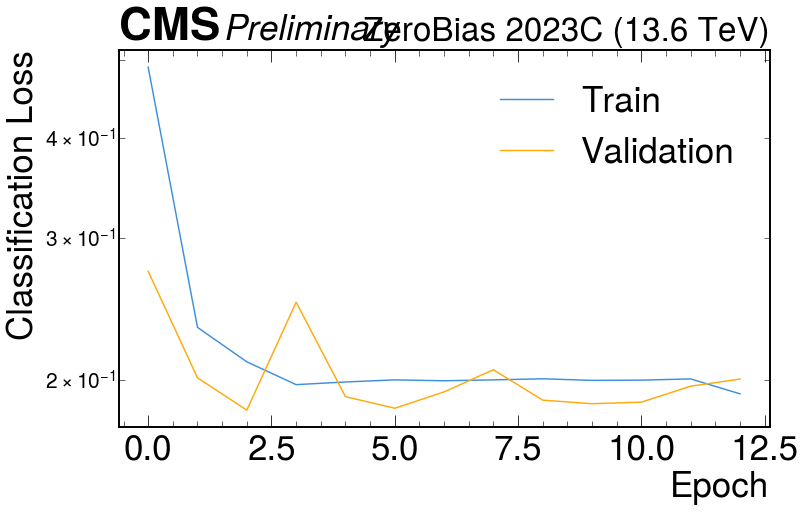

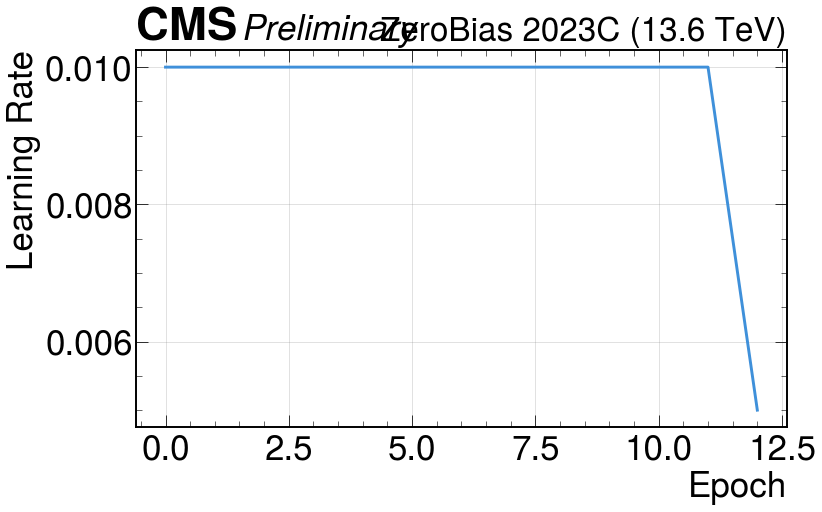

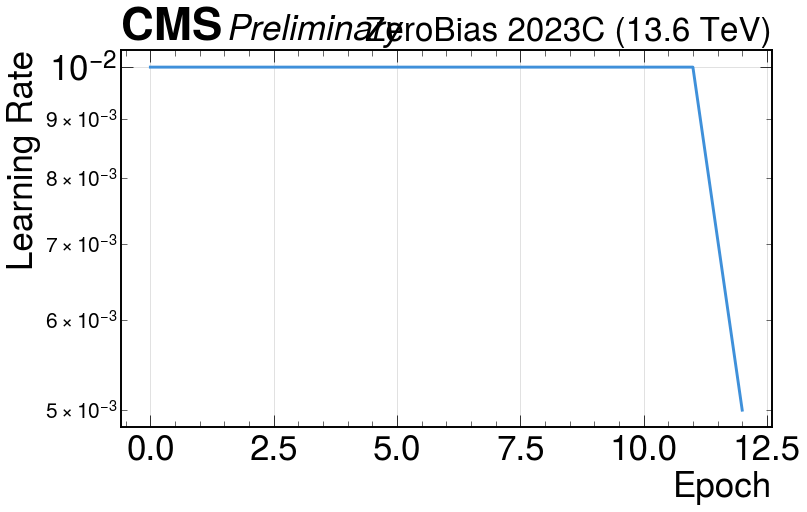

In [ ]:
plot_losses_and_learning_rates(
    results_2["train_classification_losses"],
    results_2["val_classification_losses"],
    results_2["learning_rates"],
    PLOT_FLAG,
    PLOT_PATH,
    learning_rate_2,
    batch_size_2,
    reg_strength_2,
    0,
    min_loss_improvement_2,
    early_stopping_threshold_2,
    FIGSIZE
)

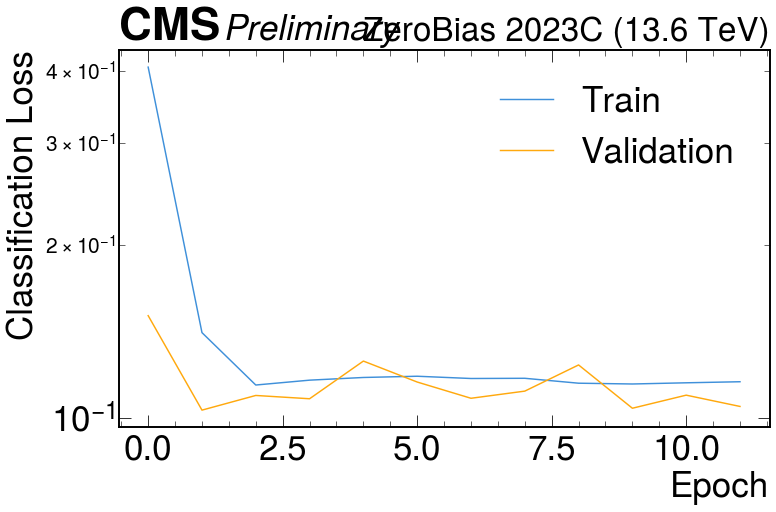

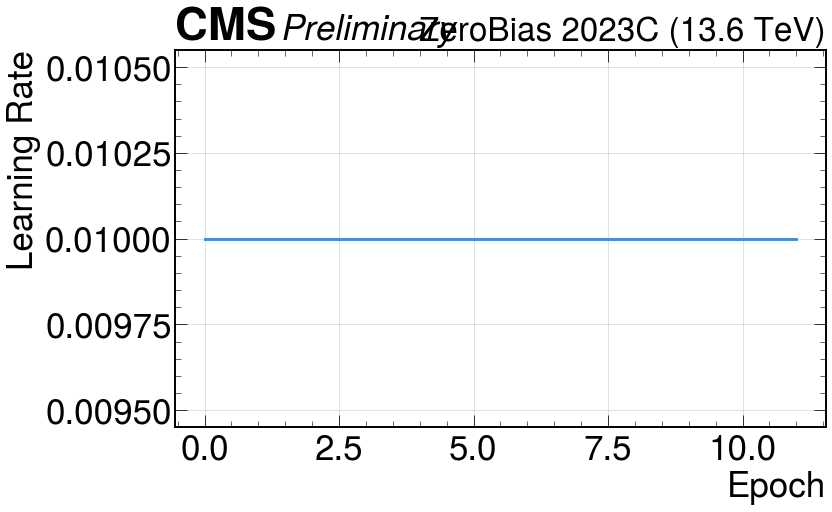

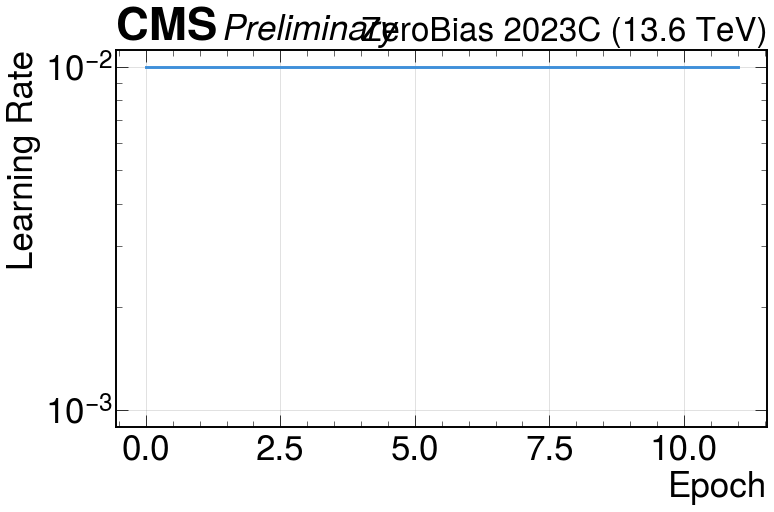

In [ ]:
plot_losses_and_learning_rates(
    results_3["train_classification_losses"],
    results_3["val_classification_losses"],
    results_3["learning_rates"],
    PLOT_FLAG,
    PLOT_PATH,
    learning_rate_3,
    batch_size_3,
    reg_strength_3,
    0,
    min_loss_improvement_3,
    early_stopping_threshold_3,
    FIGSIZE
)

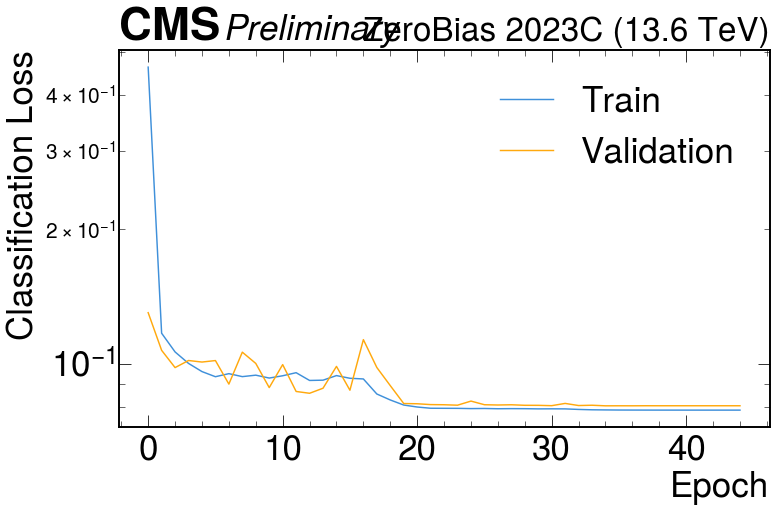

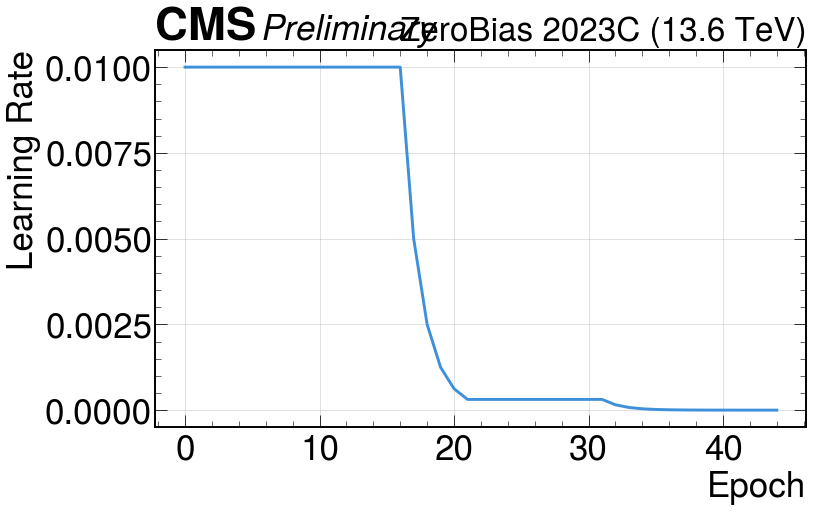

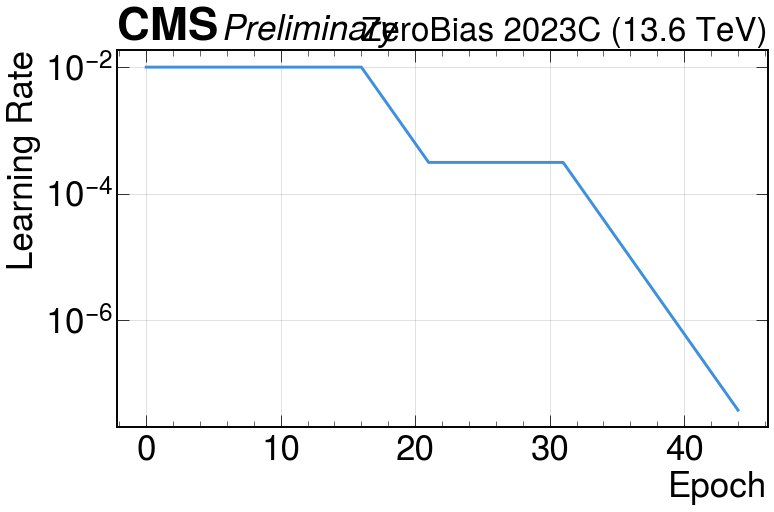

In [ ]:
plot_losses_and_learning_rates(
    results_4["train_classification_losses"],
    results_4["val_classification_losses"],
    results_4["learning_rates"],
    PLOT_FLAG,
    PLOT_PATH,
    learning_rate_4,
    batch_size_4,
    reg_strength_4,
    0,
    min_loss_improvement_4,
    early_stopping_threshold_4,
    FIGSIZE
)

## Perform multiple trainings to compute average loss (TAKES A LOT OF TIME)

In [ ]:
N_ITER = 50

In [ ]:
@tf.function
def train_step(features, targets):
    with tf.GradientTape() as tape:
        regression_targets = targets[:, :-1]
        classification_targets = targets[:, -1]
        reg_outputs, class_outputs = model(features, training=True)
        regression_loss = regression_criterion(regression_targets, reg_outputs)
        classification_loss = classification_criterion(classification_targets, class_outputs)
        loss = regression_weight * regression_loss + classification_weight * classification_loss

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return regression_loss, classification_loss, loss

@tf.function
def val_step(features, targets):
    regression_targets = targets[:, :-1]
    classification_targets = targets[:, -1]
    reg_outputs, class_outputs = model(features, training=False)
    regression_loss = regression_criterion(regression_targets, reg_outputs)
    classification_loss = classification_criterion(classification_targets, class_outputs)
    loss = regression_weight * regression_loss + classification_weight * classification_loss
    return regression_loss, classification_loss, loss

In [ ]:
full_data_ = pd.DataFrame()

for file in os.listdir(FILE_PATH):
    if file.endswith(".csv"):
        full_data_ = pd.concat([full_data_, pd.read_csv(FILE_PATH + file)], ignore_index=True)
        
full_data_ = full_data_.iloc[:, :-1]

# drop rows with ptL1 == 4.5
full_data_ = full_data_[full_data_["ptL1"] != 4.5]

# drop rows with reco eta > 1 and < -1
full_data_ = full_data_[full_data_["etaExtRecoSt2"] < 1]
full_data_ = full_data_[full_data_["etaExtRecoSt2"] > -1]

# drop rows with ptL1 > 50
full_data_ = full_data_[full_data_["ptL1"] < 50]

# drop rows with ptReco > 50
full_data_ = full_data_[full_data_["ptReco"] < 50]


# mask_1 = (full_data_.etaL1 == 0) & (np.abs(full_data_.etaExtRecoSt2) == 0)
# mask_2 = (full_data_.etaL1 != 0)

# mask = mask_1 | mask_2

# full_data_ = full_data_[mask]

full_data_["ptRecoInverse"] = 1 / full_data_["ptReco"]

full_data = full_data_[stub_features + target_features + l1_features]

full_data["chargeReco"] = full_data["chargeReco"].apply(lambda x: 0 if x == -1 else 1)

NameError: name 'stub_features' is not defined

In [ ]:
classification_criterion = losses.BinaryCrossentropy(from_logits=True)
regression_criterion     = losses.MeanAbsoluteError()

# lr scheduler
scale_factor = 0.5
patience = 5
min_loss_improvement = 0.1

classification_weight = 1
regression_weight     = 5

In [ ]:
train_regression_losses_all     = []
train_classification_losses_all = []
train_combined_losses_all       = []
val_regression_losses_all       = []
val_classification_losses_all   = []
val_combined_losses_all         = []

for i in range(N_ITER):
    
    # Hyperparameters
    input_size    = len(stub_features)
    architecture  = [input_size, 64, 32, 16, 8]
    output_size   = len(target_features)
    learning_rate = 1e-2
    num_epochs    = 300
    batch_size    = 2**10
    reg_strength  = 1e-3

    
    # Early stopping variables
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    patience = 10  # Number of epochs to wait before stopping
    early_stopping_threshold = 1e-5  # Minimum improvement in loss function to be considered as improvement


    train_val_data, test_data = train_test_split(full_data,      test_size=0.3, random_state=42)
    train_data, val_data      = train_test_split(train_val_data, test_size=0.1, random_state=42)

    # normalize the data
    for key in normalizations.keys():
        train_data[key] = train_data[key] / normalizations[key]
        val_data[key]   = val_data[key]   / normalizations[key]
        test_data[key]  = test_data[key]  / normalizations[key]
        
    
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data[stub_features].values, train_data[target_features].values)).batch(batch_size).shuffle(buffer_size=len(train_data))
    val_dataset   = tf.data.Dataset.from_tensor_slices((val_data[stub_features].values, val_data[target_features].values)).batch(batch_size)
    test_dataset  = tf.data.Dataset.from_tensor_slices((test_data[stub_features].values, test_data[target_features].values)).batch(batch_size)


    # Create the model
    model = MultiTaskNN(architecture, reg_strength=reg_strength)

    # Build the model with the batch input shape
    bs = None  # None allows for variable batch size
    model.build((bs, input_size))

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    scheduler = CustomLRScheduler(
        optimizer, 
        factor=scale_factor, 
        patience=patience, 
        min_improvement=min_loss_improvement, 
        verbose=True
    )


    train_regression_losses     = []
    train_classification_losses = []
    train_combined_losses       = []
    val_regression_losses       = []
    val_classification_losses   = []
    val_combined_losses         = []

    learning_rates = []
    
    @tf.function
    def train_step(features, targets):
        with tf.GradientTape() as tape:
            regression_targets = targets[:, :-1]
            classification_targets = targets[:, -1]
            reg_outputs, class_outputs = model(features, training=True)
            regression_loss = regression_criterion(regression_targets, reg_outputs)
            classification_loss = classification_criterion(classification_targets, class_outputs)
            loss = regression_weight * regression_loss + classification_weight * classification_loss

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        return regression_loss, classification_loss, loss

    @tf.function
    def val_step(features, targets):
        regression_targets = targets[:, :-1]
        classification_targets = targets[:, -1]
        reg_outputs, class_outputs = model(features, training=False)
        regression_loss = regression_criterion(regression_targets, reg_outputs)
        classification_loss = classification_criterion(classification_targets, class_outputs)
        loss = regression_weight * regression_loss + classification_weight * classification_loss
        return regression_loss, classification_loss, loss


    # Training loop
    for epoch in range(num_epochs):
        # Training
        running_loss                = 0.0
        running_regression_loss     = 0.0
        running_classification_loss = 0.0
        
        
        for features, targets in train_dataset:
            
            regression_loss, classification_loss, loss = train_step(features, targets)
            
            running_loss                += loss.numpy()
            running_regression_loss     += regression_loss.numpy()
            running_classification_loss += classification_loss.numpy()


            
        # Note: Remember to adjust if not using batches of equal sizes
        train_loss                = running_loss                / len(train_dataset)
        train_regression_loss     = running_regression_loss     / len(train_dataset)
        train_classification_loss = running_classification_loss / len(train_dataset)

        train_regression_losses.append(train_regression_loss)
        train_classification_losses.append(train_classification_loss)
        train_combined_losses.append(train_loss)

        # Validation
        running_loss                = 0.0
        running_regression_loss     = 0.0
        running_classification_loss = 0.0
        
        for features, targets in val_dataset:
            
            regression_loss, classification_loss, loss = val_step(features, targets)
            
            running_loss                += loss.numpy()
            running_regression_loss     += regression_loss.numpy()
            running_classification_loss += classification_loss.numpy()
        
        avg_val_loss                = running_loss                / len(val_dataset)
        avg_val_regression_loss     = running_regression_loss     / len(val_dataset)
        avg_val_classification_loss = running_classification_loss / len(val_dataset)
            
        val_regression_losses.append(avg_val_regression_loss)
        val_classification_losses.append(avg_val_classification_loss)
        val_combined_losses.append(avg_val_loss)
        
        
        current_lr = optimizer.lr.numpy()
        learning_rates.append(current_lr)
        
        
        
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Learning rate: {current_lr:.2e}")
        print(f"Train Losses - Regression: {train_regression_losses[-1]:.4f}, Classification: {train_classification_losses[-1]:.4f}, Combined: {train_combined_losses[-1]:.4f}")
        print(f"Validation Losses - Regression: {val_regression_losses[-1]:.4f}, Classification: {val_classification_losses[-1]:.4f}, Combined: {val_combined_losses[-1]:.4f}")
        print("-------------")
        
        
        scheduler.on_epoch_end(epoch, {"val_loss": avg_val_loss})

        

        # Check for early stopping based on the new criterion
        if avg_val_loss < (1 - early_stopping_threshold) * best_val_loss:  # 0.001 corresponds to 0.1%
            epochs_without_improvement = 0
            best_val_loss = min(best_val_loss, avg_val_loss)
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break
        
    train_regression_losses_all.append(train_regression_losses)
    train_classification_losses_all.append(train_classification_losses)
    train_combined_losses_all.append(train_combined_losses)
    val_regression_losses_all.append(val_regression_losses)
    val_classification_losses_all.append(val_classification_losses)
    val_combined_losses_all.append(val_combined_losses)
    
    del model
    del optimizer
    del scheduler
    del train_dataset
    del val_dataset
    del test_dataset
    del train_data
    del val_data
    del test_data
    del train_val_data

Epoch [1/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.1081, Classification: 0.1282, Combined: 0.6685
Validation Losses - Regression: 0.0584, Classification: 0.0825, Combined: 0.3743
-------------
Epoch [2/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.0399, Classification: 0.0807, Combined: 0.2800
Validation Losses - Regression: 0.0396, Classification: 0.0756, Combined: 0.2735
-------------
Epoch [3/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.0305, Classification: 0.0767, Combined: 0.2290
Validation Losses - Regression: 0.0301, Classification: 0.0725, Combined: 0.2228
-------------
Epoch [4/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.0256, Classification: 0.0753, Combined: 0.2033
Validation Losses - Regression: 0.0229, Classification: 0.0713, Combined: 0.1856
-------------
Epoch [5/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.0234, Classification: 0.0734, Combined: 0.1903
Validation Losses - Regression: 0.0204, Classifica

KeyboardInterrupt: 

In [ ]:
# compute the mean and std of the losses for each epoch
# the lists in the lists are of different lengths, so we need to pad them with the last value
# then we can compute the mean and std

train_regression_losses_all      = [x + [x[-1]] * (max(map(len, train_regression_losses_all)) - len(x)) for x in train_regression_losses_all]
train_classification_losses_all  = [x + [x[-1]] * (max(map(len, train_classification_losses_all)) - len(x)) for x in train_classification_losses_all]
train_combined_losses_all        = [x + [x[-1]] * (max(map(len, train_combined_losses_all)) - len(x)) for x in train_combined_losses_all]

val_regression_losses_all        = [x + [x[-1]] * (max(map(len, val_regression_losses_all)) - len(x)) for x in val_regression_losses_all]
val_classification_losses_all    = [x + [x[-1]] * (max(map(len, val_classification_losses_all)) - len(x)) for x in val_classification_losses_all]
val_combined_losses_all          = [x + [x[-1]] * (max(map(len, val_combined_losses_all)) - len(x)) for x in val_combined_losses_all]

train_regression_losses_mean     = np.mean(np.array(train_regression_losses_all), axis=0)[1:]
train_regression_losses_std      = np.std(np.array(train_regression_losses_all), axis=0)[1:]
train_classification_losses_mean = np.mean(np.array(train_classification_losses_all), axis=0)[1:]
train_classification_losses_std  = np.std(np.array(train_classification_losses_all), axis=0)[1:]
train_combined_losses_mean       = np.mean(np.array(train_combined_losses_all), axis=0)[1:]
train_combined_losses_std        = np.std(np.array(train_combined_losses_all), axis=0)[1:]

val_regression_losses_mean       = np.mean(np.array(val_regression_losses_all), axis=0)[1:]
val_regression_losses_std        = np.std(np.array(val_regression_losses_all), axis=0)[1:]
val_classification_losses_mean   = np.mean(np.array(val_classification_losses_all), axis=0)[1:]
val_classification_losses_std    = np.std(np.array(val_classification_losses_all), axis=0)[1:]
val_combined_losses_mean         = np.mean(np.array(val_combined_losses_all), axis=0)[1:]
val_combined_losses_std          = np.std(np.array(val_combined_losses_all), axis=0)[1:]

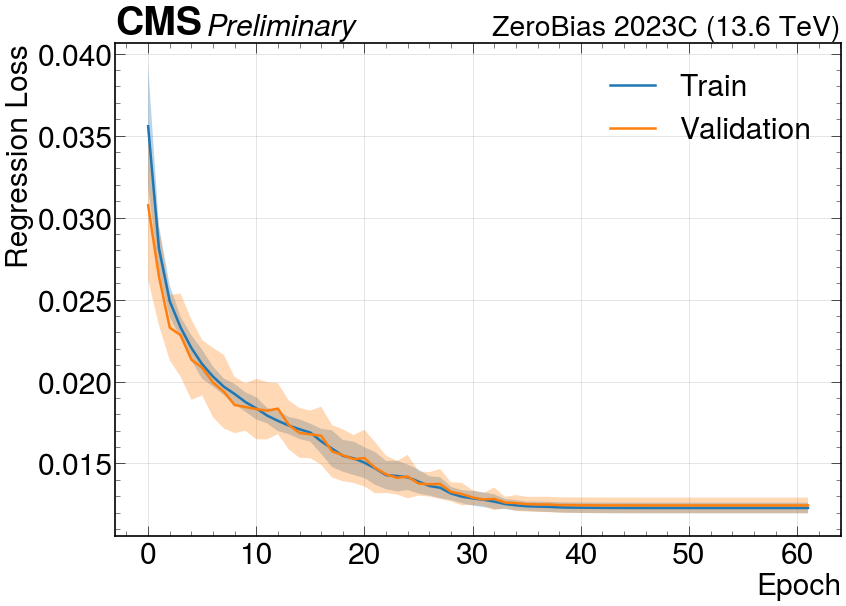

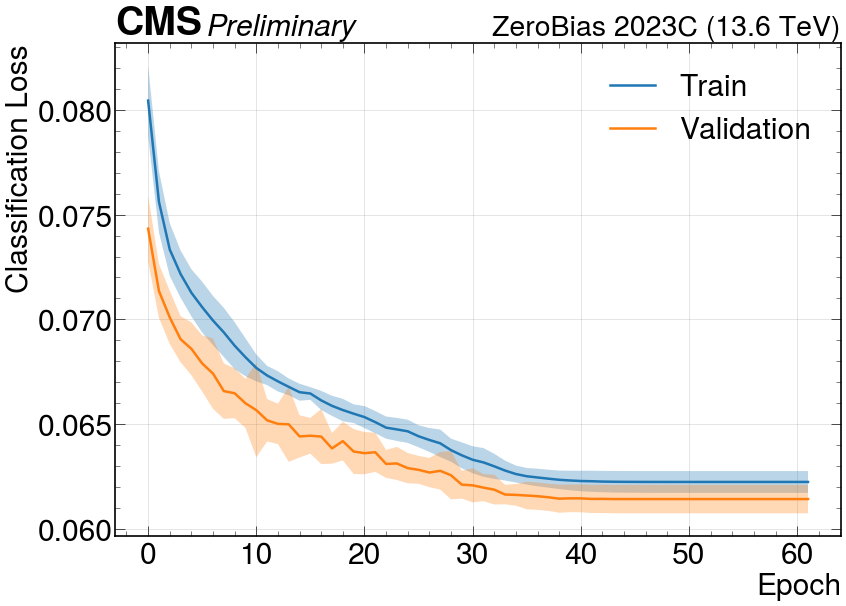

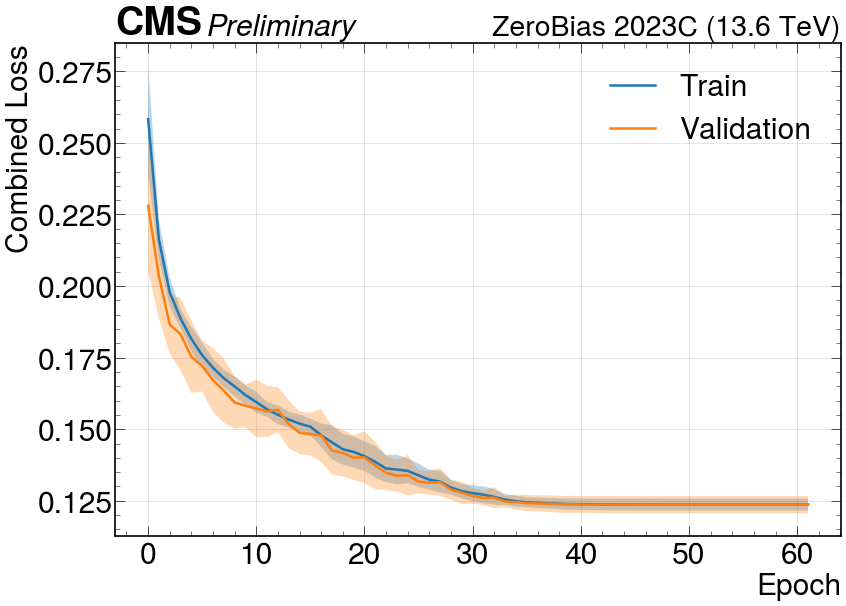

In [ ]:


# REGRESSION LOSS
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)
hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)
ax.plot(train_regression_losses_mean, label="Train", color=PALETTE[0], linewidth=3)
ax.fill_between(np.arange(len(train_regression_losses_mean)), train_regression_losses_mean - train_regression_losses_std, train_regression_losses_mean + train_regression_losses_std, alpha=0.3)
ax.plot(val_regression_losses_mean, label="Validation", color=PALETTE[-1], linewidth=3)
ax.fill_between(np.arange(len(val_regression_losses_mean)), val_regression_losses_mean - val_regression_losses_std, val_regression_losses_mean + val_regression_losses_std, alpha=0.3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Regression Loss", fontsize=36)
ax.legend(fontsize=36)
# ax.set_yscale("log")
ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}regression_loss_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()

# CLASSIFICATION LOSS
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)
hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)
ax.plot(train_classification_losses_mean, label="Train", color=PALETTE[0], linewidth=3)
ax.fill_between(np.arange(len(train_classification_losses_mean)), train_classification_losses_mean - train_classification_losses_std, train_classification_losses_mean + train_classification_losses_std, alpha=0.3)
ax.plot(val_classification_losses_mean, label="Validation", color=PALETTE[-1], linewidth=3)
ax.fill_between(np.arange(len(val_classification_losses_mean)), val_classification_losses_mean - val_classification_losses_std, val_classification_losses_mean + val_classification_losses_std, alpha=0.3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Classification Loss", fontsize=36)
ax.legend(fontsize=36)
# ax.set_yscale("log")
ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}classification_loss_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()

# COMBINED LOSS
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)
hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)
ax.plot(train_combined_losses_mean, label="Train", color=PALETTE[0], linewidth=3)
ax.fill_between(np.arange(len(train_combined_losses_mean)), train_combined_losses_mean - train_combined_losses_std, train_combined_losses_mean + train_combined_losses_std, alpha=0.3)
ax.plot(val_combined_losses_mean, label="Validation", color=PALETTE[-1], linewidth=3)
ax.fill_between(np.arange(len(val_combined_losses_mean)), val_combined_losses_mean - val_combined_losses_std, val_combined_losses_mean + val_combined_losses_std, alpha=0.3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Combined Loss", fontsize=36)
ax.legend(fontsize=36)
# ax.set_yscale("log")
ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}combined_loss_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()